### Overview
This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral.

### Objective
This project aims to perform different text cleaning techniques to extract relevant information from the Tweets. Given a message and an entity, the task is to judge the message's sentiment about the topic.

# 0. Import necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import SCORERS, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score

#Text processing libraries
import re #Regular expression
import nltk
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer #feature extraction

stop_words = set(stopwords.words('english')) 

import warnings
warnings.filterwarnings("ignore")

#  1. Load the Data into Pandas Dataframe

In [2]:
headers = ['ID', 'Topic', 'Sentiment', 'Tweet']
Data = pd.read_csv('Data/twitter_training.csv', names=headers)
Data.head(10)

,ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [3]:
Data_valid = pd.read_csv('Data/twitter_validation.csv', names=headers)
Data_valid.head(10)

,ID,Topic,Sentiment,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...


In [4]:
print(Data.shape)
print(Data_valid.shape)

(74682, 4)
(1000, 4)


In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
Data_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Topic      1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Tweet      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [7]:
Data.describe(include=object)

,Topic,Sentiment,Tweet
count,74682,74682,73996
unique,32,4,69491
top,TomClancysRainbowSix,Negative,
freq,2400,22542,172


In [8]:
for i in Data.columns:
    if Data[i].dtype == object:
        print(i,'\n', Data[i].unique(),'\n')

Topic 
 ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia'] 

Sentiment 
 ['Positive' 'Neutral' 'Negative' 'Irrelevant'] 

Tweet 
 ['im getting on borderlands and i will murder you all ,'
 'I am coming to the borders and I will kill you all,'
 'im getting on borderlands and i will kill you all,' ...
 'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice'
 'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I have no fucking

# 2. Data Cleaning & Preparation

Checking the existance of missing values, the type of variables, or integrity of data.

## 2.1. Checking for missing value

In [9]:
Data.isna().sum()

ID             0
Topic          0
Sentiment      0
Tweet        686
dtype: int64

In [10]:
#Remove entries with missing value for Tweet
Data = Data.dropna(axis=0)
Data.isna().sum()

ID           0
Topic        0
Sentiment    0
Tweet        0
dtype: int64

In [11]:
Data.shape

(73996, 4)

### 2.2. Check data for duplicate rows and remove the duplicate

In [12]:
#Check data for duplicate rows and remove the duplicate
duplicates = Data.duplicated()
sum(duplicates)

2340

In [13]:
Data=Data.drop_duplicates()
Data.shape

(71656, 4)

### 2.3. Target Variable

In [14]:
Data.Sentiment.value_counts()

Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: Sentiment, dtype: int64

In [15]:
#We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.
#Data['Sentiment'] = Data['Sentiment'].replace('Irrelevant','Neutral')

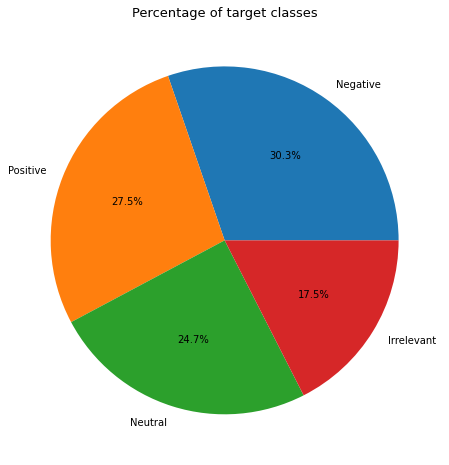

In [16]:
# Explore the target variable.

labels = Data.Sentiment.value_counts().index
sizes = Data.Sentiment.value_counts()
plt.figure(figsize = (8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of target classes',color = 'black',fontsize = 13);

# 3. Data Pre Processing

In [17]:
#Remove @mention from the Tweets
Data['Tweet_cleaned'] = Data['Tweet'].apply(lambda x: re.sub(r"@[A-Za-z0-9]+|@\s[^\s]+","",x))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
38046,5324,Hearthstone,Negative,PLEASE STOP,PLEASE STOP
48673,5955,HomeDepot,Negative,Home Depot... this is where inspiration dies,Home Depot... this is where inspiration dies
41356,1496,Battlefield,Neutral,The @Braddock512 Happy Gay Birthday mate.. If ...,The Happy Gay Birthday mate.. If I had some g...
46672,5608,HomeDepot,Irrelevant,But you do definitely have liberated blacks wh...,But you do definitely have liberated blacks wh...
13884,8782,NBA2K,Negative,@NBA2K_MyTEAM I hate this game I spent 500 and...,_MyTEAM I hate this game I spent 500 and got t...


In [18]:
#Remove #hashtags from the Tweets
Data['Tweet_cleaned'] = Data['Tweet_cleaned'].apply(lambda x: re.sub('#',"",x))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
13423,8704,NBA2K,Negative,Go home from work and think I'm going to play ...,Go home from work and think I'm going to play ...
36354,8239,Microsoft,Negative,It’s wild Halo 2 had the best video game sound...,It’s wild Halo 2 had the best video game sound...
48621,5946,HomeDepot,Neutral,Respect the king. Thighs out baby!!,Respect the king. Thighs out baby!!
65214,7969,MaddenNFL,Positive,Derrick Henry should be at the top of this list,Derrick Henry should be at the top of this list
29062,599,ApexLegends,Negative,18 LEAVE MY FRIENDS ALONE THE [UNK].,18 LEAVE MY FRIENDS ALONE THE [UNK].


In [19]:
#Remove URL
Data['Tweet_cleaned']=Data['Tweet_cleaned'].apply(lambda x: re.sub(r"http\S+",'',x))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
40334,1322,Battlefield,Negative,@ EAHelp still cant be online in Battlefield V...,"still cant be online in Battlefield V, from T..."
36661,8290,Microsoft,Negative,FBI: National actors have raided two US munici...,FBI: National actors have raided two US munici...
21396,4063,CS-GO,Negative,@CSGO @valve should fix loss problem with thei...,should fix loss problem with their indian se...
6244,274,Amazon,Irrelevant,deforestation : soy ( crops used only for farm...,deforestation : soy ( crops used only for farm...
37904,5299,Hearthstone,Negative,"C'mon @ Blizzard _ Ent, WTF with this? f fast ...","C'mon _ Ent, WTF with this? f fast please!..."


In [20]:
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english')) 
def stop_words_lemma_convert(sentence):
    tokens = [w for w in sentence.split() if not w in stop_words] #stopwords removal
    newString=''
    for i in tokens:                                                 
        newString=newString+lemmatizer.lemmatize(i)+' '    #converting words to lemma                               
    return newString.strip()   

In [21]:
Data['Tweet_cleaned']=Data['Tweet_cleaned'].apply(lambda x: stop_words_lemma_convert(x))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
17393,9781,PlayStation5(PS5),Negative,"I can hardly ever read ""PS5"" or ""piss""","I hardly ever read ""PS5"" ""piss"""
72834,8877,Nvidia,Neutral,Pretty excited about this collaboration with K...,Pretty excited collaboration KovaaK 2.0. Throu...
66143,6926,johnson&johnson,Neutral,your,
64096,7782,MaddenNFL,Negative,@EAMaddenNFL the servers down?,server down?
5494,146,Amazon,Neutral,I played in this interesting poker quiz on Ama...,I played interesting poker quiz Amazon - Try d...


In [22]:
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
27371,1110,AssassinsCreed,Positive,fucking dope. We actually pick it up again,fucking dope. We actually pick
60966,4850,GrandTheftAuto(GTA),Irrelevant,The doose is loose. What an amazing stream bac...,The doose loose. What amazing stream back play...
30552,7250,LeagueOfLegends,Positive,. Need.,. Need.
13786,8765,NBA2K,Negative,@NBA2K and i get your next hit game it came ou...,get next hit game came 2k20 left mycareer wont...
6684,351,Amazon,Negative,if you like this you’ll regret it,like you’ll regret


In [23]:
#Getting only the letters from the tweets
Data['Tweet_cleaned']=Data['Tweet_cleaned'].apply(lambda x: re.sub(r'[^A-Za-z\s]',"",x))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
67238,7114,johnson&johnson,Neutral,Johnson & Johnson Halts Talc Baby Powder Sales...,Johnson Johnson Halts Talc Baby Powder Sales ...
39617,5599,Hearthstone,Neutral,cats eat giant spiders of their sleep each yea...,cat eat giant spider sleep year Centaurs two r...
13209,8668,NBA2K,Negative,"If they don’t, the people Shall Boycott Congre...",If dont people Shall Boycott Congress
35003,8013,Microsoft,Neutral,or Post my Learn the Basics with Flipgrid on t...,Post Learn Basics Flipgrid Digital Educator Ce...
44397,11626,Verizon,Negative,@Verizon your data keep crawling this morning!...,data keep crawling morning Whats going on


In [24]:
#Lowercase
Data['Tweet_cleaned']=Data['Tweet_cleaned'].apply(lambda x: x.lower())
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned
47960,5833,HomeDepot,Negative,I FUTURE ASSISTANCE TO CAKIOINE IN A HOUSE DEP...,i future assistance to cakioine in a house dep...
31349,7383,LeagueOfLegends,Negative,"league of legends and, play rogue company! Eve...",league legend and play rogue company even better
45568,11822,Verizon,Irrelevant,And I have AT & Q T and that my service stops ...,and i at q t service stop working everyday no...
4333,1946,CallOfDutyBlackopsColdWar,Negative,Let's hope @ Treyarch does something to elimin...,lets hope something eliminate racist hateful l...
23047,4349,CS-GO,Irrelevant,"Thanks to the brave players of Halo, Call of D...",thanks brave player halo call duty goldeneye c...


In [25]:
#Count of word of each tweet
Data['words'] = Data["Tweet_cleaned"].apply(lambda x: len(x.split()))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned,words
69750,3951,Cyberpunk2077,Neutral,Exactly what I was thinking about.. . In Witch...,exactly i thinking about in witcher setting ...,28
36695,8295,Microsoft,Neutral,Huge play space. Want/Evolution of Nature? Ent...,huge play space wantevolution nature entercomo...,6
24474,4597,Google,Negative,bitch im mf bing,bitch im mf bing,4
51595,10457,RedDeadRedemption(RDR),Neutral,"@ 98RockJustin Since going out is not a thing,...",since going thing i get red dead redemption ii...,15
40494,1350,Battlefield,Neutral,I won 2 achievements in Battlefield V for 31 T...,i achievement battlefield v trueachievement ...,7


In [26]:
Data["Characters"] = Data["Tweet_cleaned"].apply(lambda x: len(x)-x.count(" "))
Data.sample(5)

,ID,Topic,Sentiment,Tweet,Tweet_cleaned,words,Characters
45957,11888,Verizon,Neutral,Percell Wright Virginia Verizon racist A Mid t...,percell wright virginia verizon racist a mid t...,11,84
16942,9703,PlayStation5(PS5),Irrelevant,Thank God. 4 After seeing the latest X1 system...,thank god after seeing latest x system tracki...,27,153
3986,1888,CallOfDutyBlackopsColdWar,Negative,"Yes, do I have to pay more to play on both con...",yes i pay play consoles,5,19
59132,3336,Facebook,Negative,"Facebook, for some crazy reason, deletes the a...",facebook crazy reason deletes account for wait...,14,80
19231,12494,WorldOfCraft,Positive,I was years old today when I found out that th...,i year old today i found composer warcraft mov...,13,70


In [27]:
Data[Data.words == 0].words.count()

1368

In [28]:
Data[Data.words == 0][["Tweet",'Tweet_cleaned']]

,Tweet,Tweet_cleaned
11,was,
53,all,
60,. . [,
62,.. [,
63,.. 45,
...,...,...
74511,@NVIDIAGeForce ],
74591,you,
74597,from,
74621,were,


In [29]:
Data.shape

(71656, 7)

In [30]:
#Drop rows with blank cleaned tweet text
Data = Data[Data.words != 0]
Data.shape

(70288, 7)

In [31]:
#Drop irrelivent columns
Data.drop(columns=['ID',"Tweet"],axis=0,inplace=True)
Data.shape

(70288, 5)

In [32]:
import quick_eda
from quick_eda.df_eda import df_eda

df_eda(Data)

Head of dataframe:

         Topic Sentiment                      Tweet_cleaned  words  Characters
0  Borderlands  Positive      im getting borderland murder       4          25
1  Borderlands  Positive         i coming border i kill all      6          21
2  Borderlands  Positive     im getting borderland kill all      5          26
3  Borderlands  Positive    im coming borderland murder all      5          27
4  Borderlands  Positive  im getting borderland  murder all      5          28
- - - - - - - - - - - - - - - - - - - - - - - -

Tail of dataframe:

        Topic Sentiment                                      Tweet_cleaned  \
74677  Nvidia  Positive  just realized windows partition mac like  year...   
74678  Nvidia  Positive  just realized mac window partition  year behin...   
74679  Nvidia  Positive  just realized window partition mac  year behin...   
74680  Nvidia  Positive  just realized window partition mac like  year ...   
74681  Nvidia  Positive  just like window parti

# 5. Machine Learning Model

In [33]:
# Separate X (features) and y (target)
# Exclude column 'salary' from ML model because it directly relates to the target variable 'income_groups'.

y = Data['Sentiment']
X = Data.drop('Sentiment',axis=1)

X.shape, y.shape

((70288, 4), (70288,))

In [34]:
# Split data to train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size = 0.15)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59744, 4), (10544, 4), (59744,), (10544,))

In [35]:
#TF-IDF
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3),min_df=10,max_features=10000) 
#Train on train data
features_train= vectorizer.fit_transform(X_train['Tweet_cleaned'])
#Apply on test data
features_valid= vectorizer.transform(X_test['Tweet_cleaned'])
#check shape
features_train.shape, features_valid.shape

((59744, 9349), (10544, 9349))

In [43]:


logr = LogisticRegression(random_state=10,max_iter=500)
logr.fit(features_train, y_train)

logr_pred = logr.predict(features_valid)
print('Logistic Regression best model confusion matrix on test data  \n',confusion_matrix(y_test, logr_pred)  )
print('*********************************************')
print('Logistic Regression best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, logr_pred)))
print('*********************************************')
print("Classification Report")
print(classification_report(y_test, logr_pred))

Logistic Regression best model confusion matrix on test data  
 [[1087  302  202  294]
 [ 111 2625  220  222]
 [ 143  368 1776  346]
 [ 157  316  255 2120]]
*********************************************
Logistic Regression best model Accuracy  on test data = 0.72
*********************************************
Classification Report
              precision    recall  f1-score   support

  Irrelevant       0.73      0.58      0.64      1885
    Negative       0.73      0.83      0.77      3178
     Neutral       0.72      0.67      0.70      2633
    Positive       0.71      0.74      0.73      2848

    accuracy                           0.72     10544
   macro avg       0.72      0.71      0.71     10544
weighted avg       0.72      0.72      0.72     10544



In [45]:
knn = KNeighborsClassifier()
knn.fit(features_train, y_train)
knn_pred = knn.predict(features_valid)
print('Knn best model confusion matrix on test data  \n',confusion_matrix(y_test, knn_pred)  )
print('*********************************************')
print('Knn best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, knn_pred)))
print('*********************************************')
print("Classification Report")
print(classification_report(y_test, knn_pred))

Knn best model confusion matrix on test data  
 [[1605  111   77   92]
 [  90 2898   97   93]
 [  90  187 2251  105]
 [ 104  217  151 2376]]
*********************************************
Knn best model Accuracy  on test data = 0.87
*********************************************
Classification Report
              precision    recall  f1-score   support

  Irrelevant       0.85      0.85      0.85      1885
    Negative       0.85      0.91      0.88      3178
     Neutral       0.87      0.85      0.86      2633
    Positive       0.89      0.83      0.86      2848

    accuracy                           0.87     10544
   macro avg       0.87      0.86      0.86     10544
weighted avg       0.87      0.87      0.87     10544



In [46]:
dt = DecisionTreeClassifier()
dt.fit(features_train, y_train)

dt_pred = dt.predict(features_valid)
print('Decision Tree best model confusion matrix on test data  \n',confusion_matrix(y_test, dt_pred)  )
print('*********************************************')
print('Decision Tree best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, dt_pred)))
print('*********************************************')
print("Classification Report")
print(classification_report(y_test, dt_pred))

Decision Tree best model confusion matrix on test data  
 [[1326  147  146  266]
 [ 137 2592  179  270]
 [ 117  223 1993  300]
 [ 114  191  190 2353]]
*********************************************
Decision Tree best model Accuracy  on test data = 0.78
*********************************************
Classification Report
              precision    recall  f1-score   support

  Irrelevant       0.78      0.70      0.74      1885
    Negative       0.82      0.82      0.82      3178
     Neutral       0.79      0.76      0.78      2633
    Positive       0.74      0.83      0.78      2848

    accuracy                           0.78     10544
   macro avg       0.78      0.78      0.78     10544
weighted avg       0.79      0.78      0.78     10544



In [ ]:
svc = SVC()
svc.fit(features_train, y_train)

svc_pred = svc.predict(features_valid)

print('SVC best model confusion matrix on test data  \n',confusion_matrix(y_test, svc_pred)  )
print('*********************************************')
print('SVC best model Precision  on test data = {:.2f}'.format(precision_score(y_test, svc_pred)))
print('SVC best model Recall on test data = {:.2f}'.format(recall_score(y_test, svc_pred)))
print('SVC best model F1 on test data  = {:.2f}'.format(f1_score(y_test, svc_pred)))
print('SVC best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, svc_pred)))
print('*********************************************')

In [50]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, random_state=13)
rfc.fit(features_train,y_train)
pred_cv = rfc.predict(features_valid)
print('Random Forest best model confusion matrix on test data  \n',confusion_matrix(y_test, pred_cv)  )
print('*********************************************')
print('Random Forest best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, pred_cv)))
print('*********************************************')
print("Classification Report")
print(classification_report(y_test, pred_cv))

Random Forest best model confusion matrix on test data  
 [[1505   95   83  202]
 [  28 2901   97  152]
 [  33  129 2278  193]
 [  30  126   94 2598]]
*********************************************
Random Forest best model Accuracy  on test data = 0.88
*********************************************
Classification Report
              precision    recall  f1-score   support

  Irrelevant       0.94      0.80      0.86      1885
    Negative       0.89      0.91      0.90      3178
     Neutral       0.89      0.87      0.88      2633
    Positive       0.83      0.91      0.87      2848

    accuracy                           0.88     10544
   macro avg       0.89      0.87      0.88     10544
weighted avg       0.88      0.88      0.88     10544

